In [1]:
%matplotlib inline


# Rhythmic Entrainment Source Separation (RESS) example

Find the linear combinations of multichannel data that maximize the
signal-to-noise ratio of the narrow-band steady-state response in the frequency
domain.

Uses `meegkit.RESS()`.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss

from meegkit import ress
from meegkit.utils import fold, matmul3d, snr_spectrum, unfold

# import config

rng = np.random.default_rng(9)

## Create synthetic data
Create synthetic data containing a single oscillatory component at 12 hz.



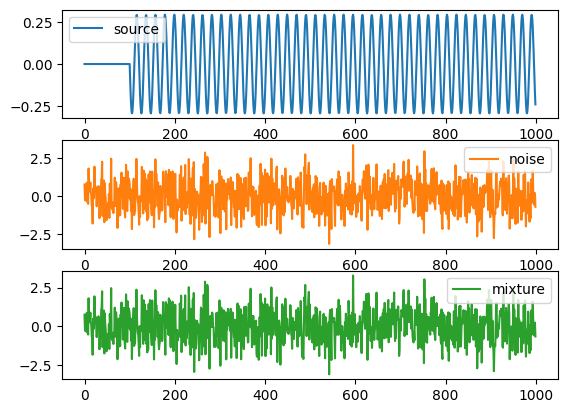

In [3]:
n_times = 1000
n_chans = 10
n_trials = 30
target = 12
sfreq = 250
noise_dim = 8
SNR = .2
t0 = 100

# source
source = np.sin(2 * np.pi * target * np.arange(n_times - t0) / sfreq)[None].T
s = source * rng.standard_normal((1, n_chans))
s = s[:, :, np.newaxis]
s = np.tile(s, (1, 1, n_trials))
signal = np.zeros((n_times, n_chans, n_trials))
signal[t0:, :, :] = s

# noise
noise = np.dot(
    unfold(rng.standard_normal((n_times, noise_dim, n_trials))),
    rng.standard_normal((noise_dim, n_chans)))
noise = fold(noise, n_times)

# mix signal and noise
signal = SNR * signal /  np.sqrt(np.mean(signal ** 2))
noise = noise / np.sqrt(np.mean(noise ** 2))
data = signal + noise

# Plot
f, ax = plt.subplots(3)
ax[0].plot(signal[:, 0, 0], c="C0", label="source")
ax[1].plot(noise[:, 1, 0], c="C1", label="noise")
ax[2].plot(data[:, 1, 0], c="C2", label="mixture")
ax[0].legend()
ax[1].legend()
ax[2].legend()

## Enhance oscillatory activity using RESS
Apply RESS



(0.0, 40.0)

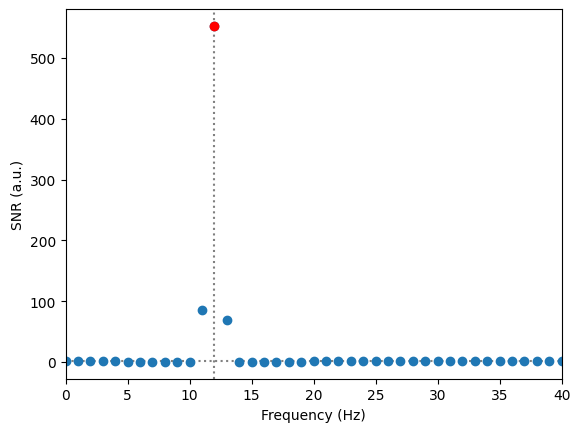

In [4]:
r = ress.RESS(sfreq=sfreq, peak_freq=target, compute_unmixing=True)
out = r.fit_transform(data)

# Compute PSD
nfft = 250
df = sfreq / nfft  # frequency resolution
bins, psd = ss.welch(np.squeeze(out), sfreq, window="hamming", nperseg=nfft,
                     noverlap=125, axis=0)
psd = psd.mean(axis=1, keepdims=True)  # average over trials
snr = snr_spectrum(psd, bins, skipbins=2, n_avg=2)

f, ax = plt.subplots(1)
ax.plot(bins, snr, "o", label="SNR")
ax.plot(bins[bins == target], snr[bins == target], "ro", label="Target SNR")
ax.axhline(1, ls=":", c="grey", zorder=0)
ax.axvline(target, ls=":", c="grey", zorder=0)
ax.set_ylabel("SNR (a.u.)")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim([0, 40])

Project components back into sensor space to see the effects of RESS on the
average SSVEP.



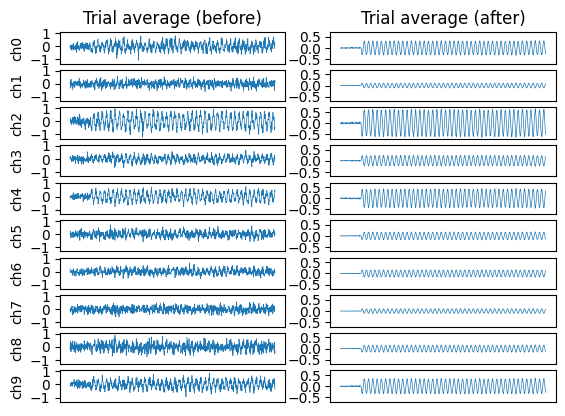

In [5]:
fromress = r.from_ress
proj = matmul3d(out, fromress)
f, ax = plt.subplots(n_chans, 2, sharey="col")
for c in range(n_chans):
    ax[c, 0].plot(data[:, c].mean(-1), lw=.5, label="data")
    ax[c, 1].plot(proj[:, c].mean(-1), lw=.5, label="projection")
    ax[c, 0].set_ylabel(f"ch{c}")
    if c < n_chans:
        ax[c, 0].set_xticks([])
        ax[c, 1].set_xticks([])

ax[0, 0].set_title("Trial average (before)")
ax[0, 1].set_title("Trial average (after)")
plt.show()